up to this point coefficients for each central specie are 4 dimensional numpy array with indexing [environmental index, radial basis/specie index, lambda, m]

Let's focus on only H centered environments:


In [2]:
coefficients = coefficients[1]
print(coefficients.shape)

(4000, 10, 6, 11)



The first step is to perform initial scaling, as it was discussed in the first tutorial. For this purposes there is class InitialScaler:

In [3]:
initial_scaler = InitialScaler(mode = 'signal integral', individually = False)
initial_scaler.fit(coefficients)
coefficients = initial_scaler.transform(coefficients)

If individually is set to False this class requires fitting before transforming the data. Otherwise fitting is not required. 

Since we are going to track parity of covariants, i. e. keep even and odd features separated, we need to split them at the begining of our calculations:

In [4]:
data_even_1, data_odd_1  = InitialTransformer().transform(coefficients)
print(type(data_even_1))
print(data_even_1.covariants_.shape)
print("even features sizes: ", data_even_1.actual_sizes_)
print("odd features sizes: ", data_odd_1.actual_sizes_)

<class 'nice.nice_utilities.Data'>
(4000, 10, 6, 11)
even features sizes:  [10, 0, 10, 0, 10, 0]
odd features sizes:  [0, 10, 0, 10, 0, 10]


The result is couple of Data instances which was already discussed in the tutorial "Calculating covariants".

All spherical expansion coefficients with even l remain constant under reflections, i. e. are even covariants, while all spherical expansion coefficients with odd l changes sign under reflection, i. e. are odd covariants. 

PCA and purifiers blocks has two versions. One to transform single instance of data of certain parity, and the second is for the same transformation of both. For example:

In [5]:
pca = IndividualLambdaPCAs(n_components = 5) #single parity version
pca.fit(data_even_1)
data_even_1_t = pca.transform(data_even_1)
print(data_even_1_t.actual_sizes_)

pca = IndividualLambdaPCAsBoth() #both version
pca.fit(data_even_1, data_odd_1)
data_even_1_t, data_odd_1_t = pca.transform(data_even_1, data_odd_1)


[5 0 5 0 5 0]


One common thing among PCA and purifiers blocks is num_to_fit semantics. Each class has num_to_fit argument in the initialization, which by default equals to '10x'. If num_to_fit is string of 'number x' format it would cause corresponding class use no more than number multiplier by number of components in case of pca, or number multiplier by number of coefficients in linear regression in case of purifiers data points. Data points are calculated as all entries of covariants. I. e. for lambda = 3 for example each environment would bring (3 * 2 + 1) data points, since dimensionality of single covariant vector is (2 * lambda + 1). If num_to_fit is int, it would do the same using the provided number as the upper bound for number of datapoints not depending on the actual number of pca components or linear regression coefficients. If total available number of data points is less than the number specified by num_to_fit class would raise warning, that there are not enough data. If num_to_fit is None corresponding block would always use all available data for fitting.

This is done because the overall model is very diverse, and different parts of the model requires very different amount of data for good fitting. Thus, it is a good idea to do such restrictions to speed up the process. 

In case of PCA if n_components specified in the constructor is less than the actual number of features given during the fit step, it would be decreased to actual number of features.
But, if number of data points is less than number of components after this possible decreasement (which make it impossible to produce such amount of components) it would raise ValueError with demand to provide more data for fitting. 

In order to do PCA step in invariants branch there is class InvariantsPCA, which actually differs from sklearn.decomposition.PCA only by num_to_fit semantics: 

In [6]:
pca = InvariantsPCA(num_to_fit = '300x')
ar  = np.random.rand(400, 10)
pca.fit(ar)
print(pca.transform(ar).shape)

(400, 10)


/home/pozdn/.local/lib/python3.6/site-packages/nice/blocks/compressors.py:218: UserWarning: Amount of provided data is less than the desired one to fit PCA. Number of components is 10, desired number of environments is 3000, actual number of environments is 400.
  self.n_components, num_fit_now, X.shape[0]))


For purifiers there are classes CovariantsPurifier, CovariantsPurifierBoth, 
InvariantsPurifier, and CovariantsIndividualPurifier. Their purpose is to transform data of single parity, both chunks of data, invariants, and single lambda channel respectively.

Their fit and transform methods accept list of covariants/invariants of previous body orders along with current body order. For example: (Let's pretend that we have already features of several body orders):

In [7]:
purifier = CovariantsPurifier(max_take = 3)
purifier.fit([data_even_1, data_even_1], data_even_1)
data_even_1_t = purifier.transform([data_even_1, data_even_1], data_even_1)

As it was already mentioned in the first tutorial purifiers can accept arbitrarily sklearn shaped linear regressors, i. e. with fit and predict methods. See tutorial "Custom regressors into purifiers" for example of such custom regressor.

In order to do expansion with thresholding euristics it is necessary to get information how important are particular features. One way is to assing .importance_ property in the Data class (setter will be done in the next version of NICE). The other is to pass features through pca, which would automatically asign importances:

In [8]:
pca = IndividualLambdaPCAsBoth() 
pca.fit(data_even_1, data_odd_1)
data_even_1, data_odd_1 = pca.transform(data_even_1, data_odd_1)

ThresholdExpansioner's fit and transform methods accept two even-odd pair of datas. If first pair is of body order v1 and second pair is of body order v2, result would be of body order v1 + v2:

In [9]:
expansioner = ThresholdExpansioner(num_expand = 200)

expansioner.fit(data_even_1, data_odd_1, data_even_1, data_odd_1)
data_even_2, data_odd_2 = expansioner.transform(data_even_1, data_odd_1,\
                                                data_even_1, data_odd_1)
print(data_even_2.actual_sizes_)
print(data_odd_2.actual_sizes_)

[ 70  69 165 142 176 121]
[  0 124 112 178 140 150]


The most time during the fitting is consumed for precomputing clebsch-gordan coefficients. Thus, in case of frequent expansioners fitting with same lambda_max, it is a good idea to precompute clebsch-gordan coefficients once, and after that just feed expansioners with them:

In [10]:
clebsch = nice.clebsch_gordan.ClebschGordan(5) # 5 is lamba max

expansioner = ThresholdExpansioner(num_expand = 200)
expansioner.fit(data_even_1, data_odd_1, data_even_1, data_odd_1, clebsch_gordan = clebsch)

It might be usefull to investigate how actually usefull is thresholding heuristic in practice. For this purpose it is possible to get "raw importances" for output features which are multiplication of importances of input features which were used in Clebsch-Gordan iteration. In other words it is the criterion for selection itself. 

Let's plot scatter plot which would show how selection criterion correlates with variance of output features for example. We will use invariants for simplicity:

(4000, 200)


Text(0, 0.5, 'variance')

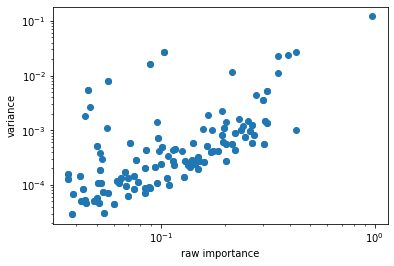

In [11]:
expansioner = ThresholdExpansioner(num_expand = 200, mode = 'invariants')
expansioner.fit(data_even_1, data_odd_1, data_even_1, data_odd_1, clebsch_gordan = clebsch)
invariants_even, _ = expansioner.transform(data_even_1, data_odd_1,\
                                                data_even_1, data_odd_1)

print(invariants_even.shape)

variances = np.mean(((invariants_even - np.mean(invariants_even, axis= 0)) ** 2), axis = 0)
raw_importances = expansioner.new_even_raw_importances_

plt.plot(np.sqrt(raw_importances), variances, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('raw importance')
plt.ylabel('variance')

There is some correlation. Thus, tresholding heuristic works. Getters for raw importances might be inserted in next version of NICE.

Standard block has the same input to fit and transform methods as TresholdExpansioner if it doesn't contain purifers:

In [12]:
block = StandardBlock(ThresholdExpansioner(num_expand = 200), None,
                      IndividualLambdaPCAsBoth(n_components = 10))
block.fit(data_even_1, data_odd_1, data_even_1, data_odd_1)
data_even_2, data_odd_2, invariants_even = block.transform(data_even_1, data_odd_1,\
                                                data_even_1, data_odd_1)
print(data_even_2.actual_sizes_)
print(invariants_even)

[10 10 10 10 10 10]
None


In this case invariants branch was None, and thus it returned None for invariants. This behavior is opposite to StandardSequence one, since it always returns invariants. If invariants branch of some block would be None it would return [:, :, 0, 0] part of covariants. 

If block contains invariants purifier, than old_even_invariants should be specified in fit and transform methods. If block contains covariants purifier, than old_even_covariants and old_odd_covariants should be specified. 

old_even_invariants should be list of 2 dimensional numpy arrays with previous invariants, old_even_covariants and old_odd_covariants should be lists with Data instances. 

In [13]:
block = StandardBlock(ThresholdExpansioner(num_expand = 200), 
                      CovariantsPurifierBoth(max_take = 10),
                      None, 
                      ThresholdExpansioner(num_expand = 200, mode = 'invariants'), 
                      InvariantsPurifier(max_take = 10), 
                      None)

block.fit(data_even_2, data_odd_2, data_even_1, data_odd_1, 
          old_even_invariants = [data_even_1.get_invariants()], # returns [:, :, 0, 0] slice which is invariants
          old_even_covariants = [data_even_1], old_odd_covariants = [data_odd_1])

data_even_3, data_odd_3, invariants_even_3 = block.transform(data_even_2, data_odd_2, data_even_1, data_odd_1, 
          old_even_invariants = [data_even_1.get_invariants()], # returns [:, :, 0, 0] slice which is invariants
          old_even_covariants = [data_even_1], old_odd_covariants = [data_odd_1])

If block contains purifiers, but fit or transform methods are called without providing necessary data it would raise ValueError.

One another usefull method is get_intermediate_shapes as in StandardSequence:

In [14]:
for key, value in block.get_intermediate_shapes().items(): # it is a dictionary
    print(key, value)

after covariants expansioner [[33, 89, 125, 140, 141, 123], [28, 84, 123, 143, 143, 125]]
after covariants purifier [[33, 89, 125, 140, 141, 123], [28, 84, 123, 143, 143, 125]]
after invariants expansioner 200
after invariants purifier 200


StandardSequence was already discussed in first tutorial "Constructing machine learning potential"

Now let's go to 1024 body order!

In [15]:

data_even_now, data_odd_now = data_even_1, data_odd_1


for _ in tqdm.tqdm(range(10)):        
    pca = IndividualLambdaPCAsBoth(10)
    pca.fit(data_even_now, data_odd_now)
    data_even_now, data_odd_now  = pca.transform(data_even_now, data_odd_now)
    expansioner = ThresholdExpansioner(50)
    expansioner.fit(data_even_now, data_odd_now, data_even_now, data_odd_now, clebsch_gordan = clebsch)
    data_even_now, data_odd_now = expansioner.transform(data_even_now, data_odd_now, data_even_now, data_odd_now)

    # very high body order cause numerical instabilities,
    # and, thus, there is need to normalize data   
    for lambd in range(6):
        if (data_even_now.actual_sizes_[lambd] > 0):
            even_factor = np.sqrt(np.mean(data_even_now.covariants_[:, :data_even_now.actual_sizes_[lambd], lambd] ** 2))
            if (even_factor > 1e-15): #catch exact zeros
                data_even_now.covariants_[:, :data_even_now.actual_sizes_[lambd], lambd] /= even_factor

        if (data_odd_now.actual_sizes_[lambd] > 0):
            odd_factor = np.sqrt(np.mean(data_odd_now.covariants_[:, :data_odd_now.actual_sizes_[lambd], lambd] ** 2))
            if (odd_factor > 1e-15): #catch exact zeros
                data_odd_now.covariants_[:, :data_odd_now.actual_sizes_[lambd], lambd] /= odd_factor


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


In [16]:
print(data_even_now.covariants_.shape)
print(data_even_now.actual_sizes_)
print(data_odd_now.actual_sizes_)

(4000, 28, 6, 11)
[ 7 19 25 28 28 25]
[ 8 18 24 26 28 26]


Done!